In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from collections import defaultdict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
from sklearn.base import clone
from sklearn.model_selection import KFold
from scipy.stats import rankdata
from fanova import fANOVA
import fanova.visualizer
import os
import ConfigSpace
import fanova.visualizer
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [2]:
# utility functions
def get_data(data, relevant_params):
    task_ids = data['task_id'].unique()
    data = data.loc[data['kernel'] == b'rbf']
    data = data[relevant_params + ['task_id'] + ['y']]
    data_dict = defaultdict()
    for task_id in task_ids:
        X_task = data.loc[data['task_id'] == task_id]
        y_task = np.array(X_task['y'], dtype=np.float)
        X_task.drop(['y', 'task_id'], 1, inplace=True)
        categorical_names = X_task.select_dtypes(include=['object']).columns
        categorical_ids = [X_task.columns.get_loc(colname) for colname in categorical_names]
        data_dict[task_id] = (X_task.as_matrix(), y_task, categorical_ids)
    return data_dict

def train_model_rs(X, y, ntrees=10):
    param_dist = {'max_depth': np.arange(3, 11),
          'n_estimators' : [100],
          'min_samples_split': np.arange(2, 11),
          'bootstrap': [True, False],
          'criterion': ['mse', 'mae']}
    clf = Pipeline(
        steps=[('random search', RandomizedSearchCV(RandomForestRegressor(ntrees), 
                                                     param_distributions=param_dist,
                                                     n_iter=200, cv=5))])
    clf.fit(X, y)
    return clf

def train_model_dt(X, y):
    param_dist = {'max_depth': np.arange(3, 5),
          'min_samples_split': np.arange(2, 11)}
    clf = Pipeline(
        steps=[('random search', RandomizedSearchCV(DecisionTreeRegressor(random_state=42), 
                                                     param_distributions=param_dist,
                                                     n_iter=200, cv=5))])
    clf.fit(X, y)
    return clf

def f(x, coeff):
    a, b, c, d, e = coeff
    return a * x[:, 0] + b * x[:, 1] + c * (x[:, 0] ** 2) + d * x[:, 0] * x[:, 1] + e * (x[:, 1] ** 2)

def f1(C, gamma, coeff):
    a, b, c, d, e, f = coeff
    return a * C + b * gamma + c * (C ** 2) + d * C * gamma + e * (gamma ** 2) + f

def precatn(task_id, model, X, y, kfolds=5, topn=5, coeff=None, loo=False):
    kf = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    splits = kf.split(X)
    scores = []
    for train_idx, test_idx in splits:
        train_x, train_y = X[train_idx], y[train_idx]
        test_x, test_y = X[test_idx], y[test_idx]
        if model is not None and loo is False:
            new_model = clone(model)
            new_model.fit(train_x, train_y)
            y_hat = new_model.predict(test_x)
        elif model is not None and loo is True:
            y_hat = model.predict(test_x)
        else:
            y_hat = f(test_x, coeff)
        y_hat_ranks = rankdata(y_hat, method='average')
        test_y_ranks = rankdata(test_y, method='average')
        y_hat_maxargs = y_hat_ranks.argsort()
        test_y_maxargs = test_y_ranks.argsort()
        cnt = 0
        for entry in y_hat_maxargs[:topn]:
            if entry in test_y_maxargs[:topn]:
                cnt += 1
        scores.append(cnt / topn)
    mean_score = np.mean(scores)
    print('Task %d; Precision at %d Score: %0.4f' %(task_id, topn, mean_score))
    return mean_score

In [3]:
meta_filename = './data/metafeatures.arff'
data_filename = './data/libsvm_svc.arff'
meta, _ = arff.loadarff(meta_filename)
data, _ = arff.loadarff(data_filename)
df_meta = pd.DataFrame(meta)
df_data = pd.DataFrame(data)
relevant_params = ['C', 'gamma']
data_dict = get_data(df_data, relevant_params)

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [4]:
simplified_surrogate = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/ssm1.pkl', 'rb'))
rf_surrogate = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/sm1.pkl', 'rb'))
rf_metamodel = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/rfmm.pkl', 'rb'))
erf_metamodel = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/erfmm.pkl', 'rb'))
agg_surrogate = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/asm.pkl', 'rb'))

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unp

In [5]:
model_params = defaultdict(list)
task_ids = list(data_dict.keys())
task_ids.remove(34536.0)
modified_data_dict = defaultdict(list)
for i, task_id in enumerate(task_ids):
    params = simplified_surrogate[task_id].coef_
    model_params['a'].append(params[0]) #C
    model_params['b'].append(params[1]) #gamma
    model_params['c'].append(params[2]) #C^2
    model_params['d'].append(params[3]) #C.gamma
    model_params['e'].append(params[4]) #gamma^2
    X_task, y_task, _ = data_dict[task_id]
    X_temp = np.empty([0,21])
    for j in range(len(X_task)):
        X_temp = np.vstack((X_temp, np.append(X_task[j,:], df_meta.loc[i].as_matrix())))
    modified_data_dict[task_id] = (X_temp, y_task)
df_model_params = pd.DataFrame(model_params)

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [6]:
y = df_model_params.as_matrix() #shape: (99,5)
X = df_meta.as_matrix() #shape: (99, 19)
print(y.shape, X.shape)

(99, 5) (99, 19)


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [13]:
new_data, _ = arff.loadarff('./data/new_data.arff')
df_new_data = pd.DataFrame(new_data)

In [18]:
df_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64983 entries, 0 to 64982
Data columns (total 29 columns):
task_id                                   64983 non-null float64
C                                         64983 non-null float64
gamma                                     64983 non-null float64
y                                         64983 non-null float64
a                                         64983 non-null float64
b                                         64983 non-null float64
c                                         64983 non-null float64
d                                         64983 non-null float64
e                                         64983 non-null float64
f                                         64983 non-null float64
AutoCorrelation                           64983 non-null float64
Dimensionality                            64983 non-null float64
MajorityClassPercentage                   64983 non-null float64
MajorityClassSize                         6498

In [25]:
# Decision Tree Regressor for metafeatures->(a-e)
dt = train_model_dt(df_new_data.iloc[:,10:len(df_new_data.columns)], df_new_data.iloc[:,4:10])
tree.export_graphviz(dt.named_steps['random search'].best_estimator_, out_file='./dt.dot')
! dot -Tpng dt.dot -o dt.png

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 18 is smaller than n_iter=200. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


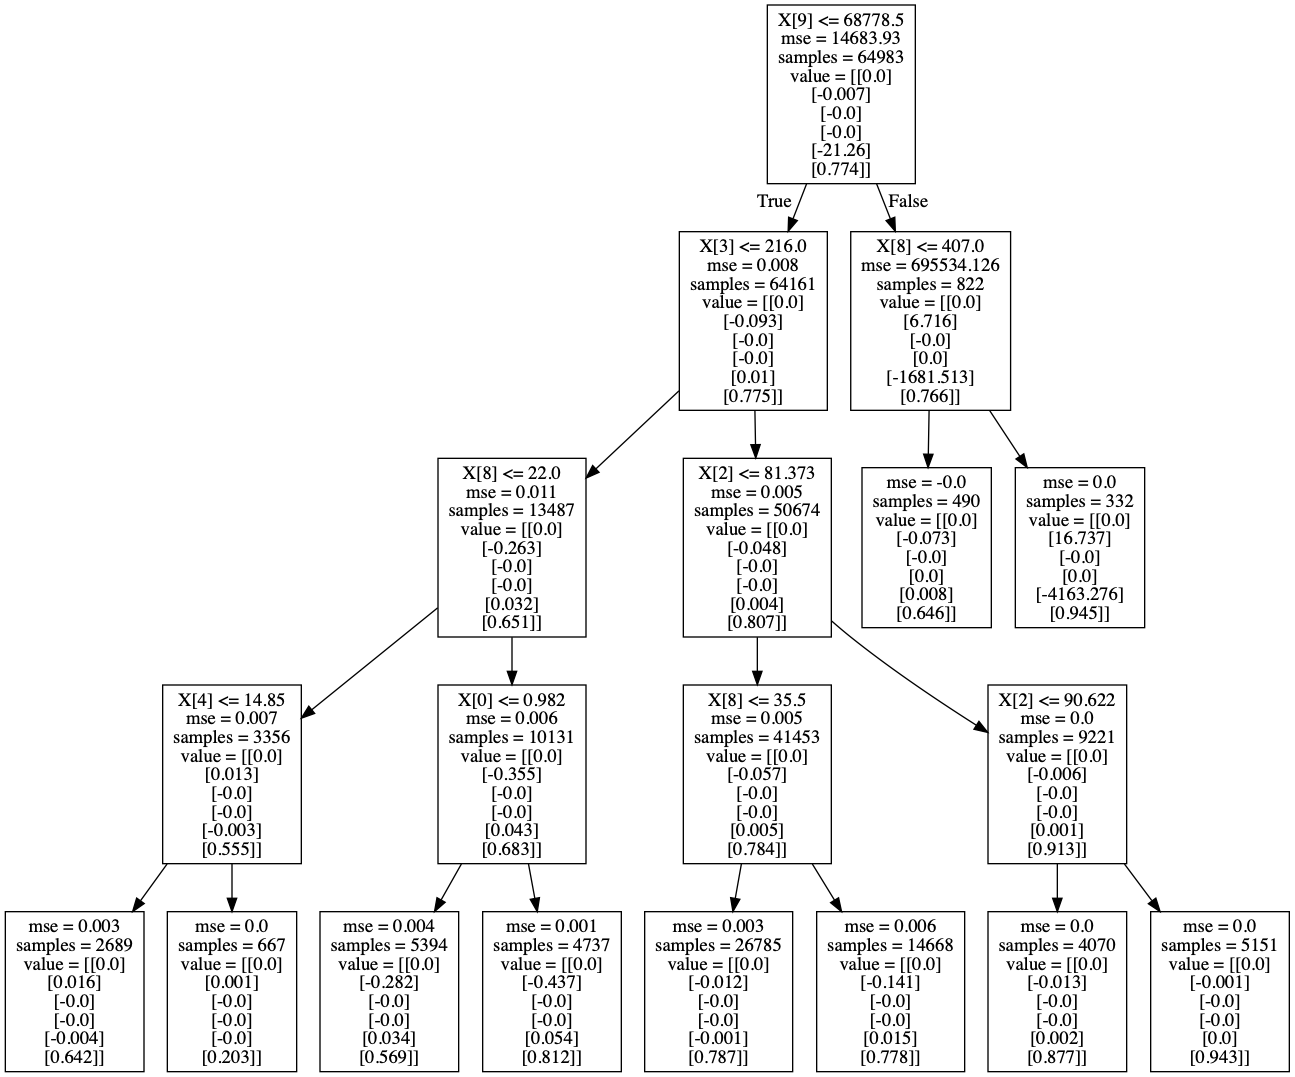

In [26]:
from IPython.display import Image
Image('dt.png')

# Contour Plots

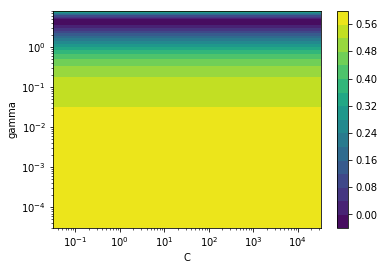

In [35]:
params = [(0.0, 0.016, -0.0, -0.0, -0.004, 0.642),\
         (0.0, 0.001, -0.0, -0.0, -0.0, 0.203),\
         (0.0, -0.282, -0.0, -0.0, 0.034, 0.569)]
df = df_new_data[['C', 'gamma']]
c = np.geomspace(np.min(df['C']), np.max(df['C']))
gamma = np.geomspace(np.min(df['gamma']), np.max(df['gamma']))
c, gamma = np.meshgrid(c, gamma)
z = np.zeros((c.shape[0], gamma.shape[0]))
for i in range(c.shape[0]):
    for j in range(gamma.shape[0]):
        z[i, j] = f1(c[i, j], gamma[i, j], params[2])
        #z[i, j] = f1(c[i, j], gamma[i, j], simplified_surrogate[3.0].coef_)
        #z[i, j] = simplified_surrogate[3.0].predict([[c[i, j], gamma[i, j], c[i, j] ** 2, c[i, j] * gamma[i, j], gamma[i, j] ** 2]])
        #z[i, j] = rf_surrogate[3.0].named_steps['random search'].best_estimator_.predict([[c[i, j], gamma[i, j]]])
fig, axes = plt.subplots(1, 1)
axes.set_xscale('log')
axes.set_yscale('log')
plt.xlabel('C')
plt.ylabel('gamma')
plt.contourf(c, gamma, z, 16, cmap=plt.cm.viridis)
plt.colorbar()

In [12]:
simplified_surrogate[3.0].coef_

array([ 1.94536685e-05, -1.02226442e-01, -5.70554670e-10, -2.00263769e-06,
        6.47326647e-03])

# Feature importances for Extended RF model

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Try

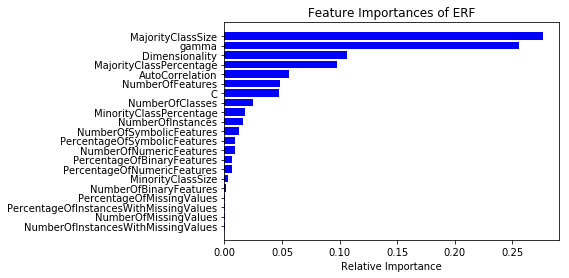

In [9]:
# for name, importance in zip(['C', 'gamma'] + list(df_meta.columns), erf_metamodel.named_steps['random search'].best_estimator_.feature_importances_):
#     print(name, "=", importance)
erf_metamodel_wloo = pickle.load(open('/Users/prernakashyap/Documents/columbia/sem1/research/models/erf.pkl', 'rb'))
features = ['C', 'gamma'] + list(df_meta.columns)
importances = erf_metamodel_wloo.named_steps['random search'].best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances of ERF')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Calculate scores for all models

In [13]:
simplified_surrogate_scores = []
rf_metamodel_scores = []
metamodel_scores = []
rf_surrogate_scores = []
aggregate_surrogate_scores = []
erf_metamodel_scores = []
rf_loo_scores = []

for i, task_id in enumerate(task_ids):
    X_task, y_task, _ = data_dict[task_id]

    # data for leave one out for metamodels
    loo_meta = df_meta.copy()
    loo_meta = loo_meta.drop([i], axis=0)
    loo_model_params = df_model_params.copy()
    loo_model_params = loo_model_params.drop([i], axis=0)
    y_meta = loo_model_params.as_matrix()
    X_meta = loo_meta.as_matrix()
    
    # leave one out for aggregate surrogate
    X_agg = np.empty([0, 2])
    y_agg = np.empty([0, 5])
    for j, t in enumerate(task_ids):
        if t != task_id:
            X_agg = np.vstack((X_agg, data_dict[t][0]))
            y_agg = np.vstack((y_agg, np.tile(y[j,:], (len(data_dict[t][1]),1))))
    
    # leave one out for leave one out random forest surrogate
    X_rf = np.empty([0, 2])
    y_rf = np.empty([0, ])
    for j, t in enumerate(task_ids):
        if t != task_id:
            X_rf = np.vstack((X_rf, data_dict[t][0]))
            y_rf = np.append(y_rf, data_dict[t][1])

    # linear aggregate surrogate which predicts (a-e) from c and gamma
    loo_agg_surrogate = LinearRegression()
    loo_agg_surrogate.fit(X_agg, y_agg)
    loo_agg_surrogate_coeff = np.mean(loo_agg_surrogate.predict(X_task), axis=0)
    print('aggregate surrogate model',)
    aggregate_surrogate_scores.append(precatn(task_id, None, X_task, y_task, topn=20, coeff=tuple(loo_agg_surrogate_coeff)))
    
     # random forest aggregate surrogate which predicts y from c and gamma with loo
    loo_rf_surrogate = rf_surrogate[task_id].named_steps['random search'].best_estimator_
    loo_rf_surrogate.fit(X_rf, y_rf)
    print('random forest surrogate model with leave one out',)
    rf_loo_scores.append(precatn(task_id, loo_rf_surrogate, X_task, y_task, topn=20, loo=True))
    
    # leave one out random forest metamodel
#     loo_rf_metamodel = train_model_rs(X_meta, y_meta)
    loo_rf_metamodel = rf_metamodel[task_id]
    loo_rf_metamodel_coeff = loo_rf_metamodel.predict(X[i,:].reshape(1,-1))[0]
    print('random forest metamodel',)
    rf_metamodel_scores.append(precatn(task_id, None, X_task, y_task, topn=20, coeff=tuple(loo_rf_metamodel_coeff), loo=True))
    
    # leave one out random forest surrogate which predicts y from c, gamma and metafeatures
#     loo_rf_metamodel = train_model_rs(X_ext, y_ext)
    loo_rf_metamodel = erf_metamodel[task_id]
    print('extended random forest metamodel',)
    erf_metamodel_scores.append(precatn(task_id, loo_rf_metamodel, modified_data_dict[task_id][0], modified_data_dict[task_id][1], topn=20, loo=True))

    # leave one out simplified metamodel
    loo_metamodel = LinearRegression()
    loo_metamodel.fit(X_meta, y_meta)
    loo_metamodel_coeff = loo_metamodel.predict(X[i,:].reshape(1,-1))[0]
    print('simplified metamodel',)
    metamodel_scores.append(precatn(task_id, None, X_task, y_task, topn=20, coeff=tuple(loo_metamodel_coeff)))

    # simplified surrogate which predicts y from c and gamma
    print('simplified surrogate model',)
    simplified_surrogate_scores.append(precatn(task_id, simplified_surrogate[task_id], X_task, y_task, topn=20))

    # random forest surrogate which predicts y from c and gamma
    print('random forest surrogate model',)
    rf_surrogate_scores.append(precatn(task_id, rf_surrogate[task_id].named_steps['random search'].best_estimator_, X_task, y_task, topn=20))


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


aggregate surrogate model
Task 3; Precision at 20 Score: 0.7300
random forest surrogate model with leave one out
Task 3; Precision at 20 Score: 0.8600
random forest metamodel
Task 3; Precision at 20 Score: 0.6600
extended random forest metamodel
Task 3; Precision at 20 Score: 0.5900
simplified metamodel
Task 3; Precision at 20 Score: 0.5300
simplified surrogate model
Task 3; Precision at 20 Score: 0.7400
random forest surrogate model
Task 3; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 6; Precision at 20 Score: 0.6400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 6; Precision at 20 Score: 0.5700
random forest metamodel
Task 6; Precision at 20 Score: 0.5400
extended random forest metamodel
Task 6; Precision at 20 Score: 0.5800
simplified metamodel
Task 6; Precision at 20 Score: 0.5900
simplified surrogate model
Task 6; Precision at 20 Score: 0.5900
random forest surrogate model
Task 6; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 11; Precision at 20 Score: 0.6100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 11; Precision at 20 Score: 0.6400
random forest metamodel
Task 11; Precision at 20 Score: 0.7200
extended random forest metamodel
Task 11; Precision at 20 Score: 0.6400
simplified metamodel
Task 11; Precision at 20 Score: 0.4800
simplified surrogate model
Task 11; Precision at 20 Score: 0.6100
random forest surrogate model
Task 11; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 12; Precision at 20 Score: 0.7600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 12; Precision at 20 Score: 0.9000
random forest metamodel
Task 12; Precision at 20 Score: 0.8400
extended random forest metamodel
Task 12; Precision at 20 Score: 0.9000
simplified metamodel
Task 12; Precision at 20 Score: 0.4100
simplified surrogate model
Task 12; Precision at 20 Score: 0.8300
random forest surrogate model
Task 12; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 14; Precision at 20 Score: 0.8000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14; Precision at 20 Score: 0.9300
random forest metamodel
Task 14; Precision at 20 Score: 0.7900
extended random forest metamodel
Task 14; Precision at 20 Score: 0.8700
simplified metamodel
Task 14; Precision at 20 Score: 0.5300
simplified surrogate model
Task 14; Precision at 20 Score: 0.8600
random forest surrogate model
Task 14; Precision at 20 Score: 0.9100
aggregate surrogate model
Task 15; Precision at 20 Score: 0.6000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 15; Precision at 20 Score: 0.6200
random forest metamodel
Task 15; Precision at 20 Score: 0.6000
extended random forest metamodel
Task 15; Precision at 20 Score: 0.7300
simplified metamodel
Task 15; Precision at 20 Score: 0.8200
simplified surrogate model
Task 15; Precision at 20 Score: 0.8700
random forest surrogate model
Task 15; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 16; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 16; Precision at 20 Score: 0.8600
random forest metamodel
Task 16; Precision at 20 Score: 0.7600
extended random forest metamodel
Task 16; Precision at 20 Score: 0.8700
simplified metamodel
Task 16; Precision at 20 Score: 0.5200
simplified surrogate model
Task 16; Precision at 20 Score: 0.7300
random forest surrogate model
Task 16; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 18; Precision at 20 Score: 0.7300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 18; Precision at 20 Score: 0.6500
random forest metamodel
Task 18; Precision at 20 Score: 0.6900
extended random forest metamodel
Task 18; Precision at 20 Score: 0.6100
simplified metamodel
Task 18; Precision at 20 Score: 0.5200
simplified surrogate model
Task 18; Precision at 20 Score: 0.7300
random forest surrogate model
Task 18; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 20; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 20; Precision at 20 Score: 0.7900
random forest metamodel
Task 20; Precision at 20 Score: 0.5300
extended random forest metamodel
Task 20; Precision at 20 Score: 0.8000
simplified metamodel
Task 20; Precision at 20 Score: 0.6800
simplified surrogate model
Task 20; Precision at 20 Score: 0.7500
random forest surrogate model
Task 20; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 21; Precision at 20 Score: 0.7900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 21; Precision at 20 Score: 0.7400
random forest metamodel
Task 21; Precision at 20 Score: 0.7400
extended random forest metamodel
Task 21; Precision at 20 Score: 0.6000
simplified metamodel
Task 21; Precision at 20 Score: 0.6100
simplified surrogate model
Task 21; Precision at 20 Score: 0.7700
random forest surrogate model
Task 21; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 22; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 22; Precision at 20 Score: 0.8000
random forest metamodel
Task 22; Precision at 20 Score: 0.7100
extended random forest metamodel
Task 22; Precision at 20 Score: 0.7900
simplified metamodel
Task 22; Precision at 20 Score: 0.4400
simplified surrogate model
Task 22; Precision at 20 Score: 0.7100
random forest surrogate model
Task 22; Precision at 20 Score: 0.9100
aggregate surrogate model
Task 23; Precision at 20 Score: 0.6000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 23; Precision at 20 Score: 0.8100
random forest metamodel
Task 23; Precision at 20 Score: 0.4900
extended random forest metamodel
Task 23; Precision at 20 Score: 0.7400
simplified metamodel
Task 23; Precision at 20 Score: 0.4100
simplified surrogate model
Task 23; Precision at 20 Score: 0.6900
random forest surrogate model
Task 23; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 24; Precision at 20 Score: 0.7100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 24; Precision at 20 Score: 0.9100
random forest metamodel
Task 24; Precision at 20 Score: 0.4900
extended random forest metamodel
Task 24; Precision at 20 Score: 0.8300
simplified metamodel
Task 24; Precision at 20 Score: 0.2700
simplified surrogate model
Task 24; Precision at 20 Score: 0.7100
random forest surrogate model
Task 24; Precision at 20 Score: 0.6600
aggregate surrogate model
Task 28; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 28; Precision at 20 Score: 0.9300
random forest metamodel
Task 28; Precision at 20 Score: 0.8500
extended random forest metamodel
Task 28; Precision at 20 Score: 0.8800
simplified metamodel
Task 28; Precision at 20 Score: 0.8100
simplified surrogate model
Task 28; Precision at 20 Score: 0.7800
random forest surrogate model
Task 28; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 29; Precision at 20 Score: 0.6400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 29; Precision at 20 Score: 0.6900
random forest metamodel
Task 29; Precision at 20 Score: 0.7600
extended random forest metamodel
Task 29; Precision at 20 Score: 0.7500
simplified metamodel
Task 29; Precision at 20 Score: 0.3900
simplified surrogate model
Task 29; Precision at 20 Score: 0.8800
random forest surrogate model
Task 29; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 31; Precision at 20 Score: 0.6600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 31; Precision at 20 Score: 0.7300
random forest metamodel
Task 31; Precision at 20 Score: 0.4800
extended random forest metamodel
Task 31; Precision at 20 Score: 0.6800
simplified metamodel
Task 31; Precision at 20 Score: 0.3400
simplified surrogate model
Task 31; Precision at 20 Score: 0.7800
random forest surrogate model
Task 31; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 32; Precision at 20 Score: 0.7300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 32; Precision at 20 Score: 0.7100
random forest metamodel
Task 32; Precision at 20 Score: 0.7400
extended random forest metamodel
Task 32; Precision at 20 Score: 0.8200
simplified metamodel
Task 32; Precision at 20 Score: 0.7100
simplified surrogate model
Task 32; Precision at 20 Score: 0.7000
random forest surrogate model
Task 32; Precision at 20 Score: 0.8500
aggregate surrogate model
Task 36; Precision at 20 Score: 0.6100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 36; Precision at 20 Score: 0.6400
random forest metamodel
Task 36; Precision at 20 Score: 0.4200
extended random forest metamodel
Task 36; Precision at 20 Score: 0.6600
simplified metamodel
Task 36; Precision at 20 Score: 0.7100
simplified surrogate model
Task 36; Precision at 20 Score: 0.7200
random forest surrogate model
Task 36; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 37; Precision at 20 Score: 0.5700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 37; Precision at 20 Score: 0.8000
random forest metamodel
Task 37; Precision at 20 Score: 0.4200
extended random forest metamodel
Task 37; Precision at 20 Score: 0.6500
simplified metamodel
Task 37; Precision at 20 Score: 0.8900
simplified surrogate model
Task 37; Precision at 20 Score: 0.8400
random forest surrogate model
Task 37; Precision at 20 Score: 0.8500
aggregate surrogate model
Task 41; Precision at 20 Score: 0.7800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 41; Precision at 20 Score: 0.9200
random forest metamodel
Task 41; Precision at 20 Score: 0.5800
extended random forest metamodel
Task 41; Precision at 20 Score: 0.8800
simplified metamodel
Task 41; Precision at 20 Score: 0.1900
simplified surrogate model
Task 41; Precision at 20 Score: 0.8300
random forest surrogate model
Task 41; Precision at 20 Score: 0.9200
aggregate surrogate model
Task 43; Precision at 20 Score: 0.6600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 43; Precision at 20 Score: 0.8500
random forest metamodel
Task 43; Precision at 20 Score: 0.6400
extended random forest metamodel
Task 43; Precision at 20 Score: 0.8000
simplified metamodel
Task 43; Precision at 20 Score: 0.4500
simplified surrogate model
Task 43; Precision at 20 Score: 0.7700
random forest surrogate model
Task 43; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 45; Precision at 20 Score: 0.7100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 45; Precision at 20 Score: 0.8200
random forest metamodel
Task 45; Precision at 20 Score: 0.5200
extended random forest metamodel
Task 45; Precision at 20 Score: 0.7700
simplified metamodel
Task 45; Precision at 20 Score: 0.4800
simplified surrogate model
Task 45; Precision at 20 Score: 0.7700
random forest surrogate model
Task 45; Precision at 20 Score: 0.8800
aggregate surrogate model
Task 49; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 49; Precision at 20 Score: 0.8500
random forest metamodel
Task 49; Precision at 20 Score: 0.6700
extended random forest metamodel
Task 49; Precision at 20 Score: 0.7400
simplified metamodel
Task 49; Precision at 20 Score: 0.4300
simplified surrogate model
Task 49; Precision at 20 Score: 0.7600
random forest surrogate model
Task 49; Precision at 20 Score: 0.8400
aggregate surrogate model
Task 53; Precision at 20 Score: 0.6500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 53; Precision at 20 Score: 0.7400
random forest metamodel
Task 53; Precision at 20 Score: 0.6800
extended random forest metamodel
Task 53; Precision at 20 Score: 0.7800
simplified metamodel
Task 53; Precision at 20 Score: 0.5000
simplified surrogate model
Task 53; Precision at 20 Score: 0.6300
random forest surrogate model
Task 53; Precision at 20 Score: 0.8800
aggregate surrogate model
Task 58; Precision at 20 Score: 0.6700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 58; Precision at 20 Score: 0.6700
random forest metamodel
Task 58; Precision at 20 Score: 0.6200
extended random forest metamodel
Task 58; Precision at 20 Score: 0.7400
simplified metamodel
Task 58; Precision at 20 Score: 0.3500
simplified surrogate model
Task 58; Precision at 20 Score: 0.7600
random forest surrogate model
Task 58; Precision at 20 Score: 0.8100
aggregate surrogate model
Task 219; Precision at 20 Score: 0.5200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 219; Precision at 20 Score: 0.5100
random forest metamodel
Task 219; Precision at 20 Score: 0.5600
extended random forest metamodel
Task 219; Precision at 20 Score: 0.5400
simplified metamodel
Task 219; Precision at 20 Score: 0.5500
simplified surrogate model
Task 219; Precision at 20 Score: 0.9100
random forest surrogate model
Task 219; Precision at 20 Score: 0.9600
aggregate surrogate model
Task 2074; Precision at 20 Score: 0.6200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 2074; Precision at 20 Score: 0.6200
random forest metamodel
Task 2074; Precision at 20 Score: 0.7300
extended random forest metamodel
Task 2074; Precision at 20 Score: 0.7200
simplified metamodel
Task 2074; Precision at 20 Score: 0.6100
simplified surrogate model
Task 2074; Precision at 20 Score: 0.4600
random forest surrogate model
Task 2074; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 2079; Precision at 20 Score: 0.7300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 2079; Precision at 20 Score: 0.9200
random forest metamodel
Task 2079; Precision at 20 Score: 0.5000
extended random forest metamodel
Task 2079; Precision at 20 Score: 0.9000
simplified metamodel
Task 2079; Precision at 20 Score: 0.2500
simplified surrogate model
Task 2079; Precision at 20 Score: 0.8600
random forest surrogate model
Task 2079; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 3021; Precision at 20 Score: 0.6800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3021; Precision at 20 Score: 0.7200
random forest metamodel
Task 3021; Precision at 20 Score: 0.5900
extended random forest metamodel
Task 3021; Precision at 20 Score: 0.6700
simplified metamodel
Task 3021; Precision at 20 Score: 0.6700
simplified surrogate model
Task 3021; Precision at 20 Score: 0.6500
random forest surrogate model
Task 3021; Precision at 20 Score: 0.7700
aggregate surrogate model
Task 3022; Precision at 20 Score: 0.6900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3022; Precision at 20 Score: 0.6300
random forest metamodel
Task 3022; Precision at 20 Score: 0.4400
extended random forest metamodel
Task 3022; Precision at 20 Score: 0.6600
simplified metamodel
Task 3022; Precision at 20 Score: 0.7000
simplified surrogate model
Task 3022; Precision at 20 Score: 0.7800
random forest surrogate model
Task 3022; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 3481; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3481; Precision at 20 Score: 0.8300
random forest metamodel
Task 3481; Precision at 20 Score: 0.8500
extended random forest metamodel
Task 3481; Precision at 20 Score: 0.9300
simplified metamodel
Task 3481; Precision at 20 Score: 0.8300
simplified surrogate model
Task 3481; Precision at 20 Score: 0.8000
random forest surrogate model
Task 3481; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 3485; Precision at 20 Score: 0.6800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3485; Precision at 20 Score: 0.8500
random forest metamodel
Task 3485; Precision at 20 Score: 0.5500
extended random forest metamodel
Task 3485; Precision at 20 Score: 0.9400
simplified metamodel
Task 3485; Precision at 20 Score: 0.7600
simplified surrogate model
Task 3485; Precision at 20 Score: 0.8000
random forest surrogate model
Task 3485; Precision at 20 Score: 0.9600
aggregate surrogate model
Task 3492; Precision at 20 Score: 0.6800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3492; Precision at 20 Score: 0.7400
random forest metamodel
Task 3492; Precision at 20 Score: 0.6900
extended random forest metamodel
Task 3492; Precision at 20 Score: 0.7000
simplified metamodel
Task 3492; Precision at 20 Score: 0.5100
simplified surrogate model
Task 3492; Precision at 20 Score: 0.7200
random forest surrogate model
Task 3492; Precision at 20 Score: 0.8500
aggregate surrogate model
Task 3493; Precision at 20 Score: 0.8100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3493; Precision at 20 Score: 0.7000
random forest metamodel
Task 3493; Precision at 20 Score: 0.8600
extended random forest metamodel
Task 3493; Precision at 20 Score: 0.5700
simplified metamodel
Task 3493; Precision at 20 Score: 0.4300
simplified surrogate model
Task 3493; Precision at 20 Score: 0.7600
random forest surrogate model
Task 3493; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 3494; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3494; Precision at 20 Score: 0.7500
random forest metamodel
Task 3494; Precision at 20 Score: 0.6900
extended random forest metamodel
Task 3494; Precision at 20 Score: 0.6800
simplified metamodel
Task 3494; Precision at 20 Score: 0.5500
simplified surrogate model
Task 3494; Precision at 20 Score: 0.7000
random forest surrogate model
Task 3494; Precision at 20 Score: 0.7800
aggregate surrogate model
Task 3510; Precision at 20 Score: 0.6500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3510; Precision at 20 Score: 0.4600
random forest metamodel
Task 3510; Precision at 20 Score: 0.5500
extended random forest metamodel
Task 3510; Precision at 20 Score: 0.6200
simplified metamodel
Task 3510; Precision at 20 Score: 0.5000
simplified surrogate model
Task 3510; Precision at 20 Score: 0.5600
random forest surrogate model
Task 3510; Precision at 20 Score: 0.8700
aggregate surrogate model
Task 3512; Precision at 20 Score: 0.6300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3512; Precision at 20 Score: 0.8600
random forest metamodel
Task 3512; Precision at 20 Score: 0.5800
extended random forest metamodel
Task 3512; Precision at 20 Score: 0.8400
simplified metamodel
Task 3512; Precision at 20 Score: 0.3800
simplified surrogate model
Task 3512; Precision at 20 Score: 0.6500
random forest surrogate model
Task 3512; Precision at 20 Score: 0.9200
aggregate surrogate model
Task 3543; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3543; Precision at 20 Score: 0.8500
random forest metamodel
Task 3543; Precision at 20 Score: 0.5600
extended random forest metamodel
Task 3543; Precision at 20 Score: 0.6700
simplified metamodel
Task 3543; Precision at 20 Score: 0.7400
simplified surrogate model
Task 3543; Precision at 20 Score: 0.6900
random forest surrogate model
Task 3543; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 3549; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3549; Precision at 20 Score: 0.9200
random forest metamodel
Task 3549; Precision at 20 Score: 0.6600
extended random forest metamodel
Task 3549; Precision at 20 Score: 0.9100
simplified metamodel
Task 3549; Precision at 20 Score: 0.4400
simplified surrogate model
Task 3549; Precision at 20 Score: 0.7700
random forest surrogate model
Task 3549; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 3560; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3560; Precision at 20 Score: 0.7800
random forest metamodel
Task 3560; Precision at 20 Score: 0.5300
extended random forest metamodel
Task 3560; Precision at 20 Score: 0.7900
simplified metamodel
Task 3560; Precision at 20 Score: 0.4000
simplified surrogate model
Task 3560; Precision at 20 Score: 0.7700
random forest surrogate model
Task 3560; Precision at 20 Score: 0.7700
aggregate surrogate model
Task 3561; Precision at 20 Score: 0.7900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3561; Precision at 20 Score: 0.8500
random forest metamodel
Task 3561; Precision at 20 Score: 0.7600
extended random forest metamodel
Task 3561; Precision at 20 Score: 0.8600
simplified metamodel
Task 3561; Precision at 20 Score: 0.7200
simplified surrogate model
Task 3561; Precision at 20 Score: 0.8500
random forest surrogate model
Task 3561; Precision at 20 Score: 0.9200
aggregate surrogate model
Task 3567; Precision at 20 Score: 0.7500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3567; Precision at 20 Score: 0.8700
random forest metamodel
Task 3567; Precision at 20 Score: 0.7200
extended random forest metamodel
Task 3567; Precision at 20 Score: 0.8800
simplified metamodel
Task 3567; Precision at 20 Score: 0.4600
simplified surrogate model
Task 3567; Precision at 20 Score: 0.8200
random forest surrogate model
Task 3567; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 3573; Precision at 20 Score: 0.9300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3573; Precision at 20 Score: 0.9200
random forest metamodel
Task 3573; Precision at 20 Score: 0.9200
extended random forest metamodel
Task 3573; Precision at 20 Score: 0.9300
simplified metamodel
Task 3573; Precision at 20 Score: 0.9300
simplified surrogate model
Task 3573; Precision at 20 Score: 0.9200
random forest surrogate model
Task 3573; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 3889; Precision at 20 Score: 0.7500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3889; Precision at 20 Score: 0.8600
random forest metamodel
Task 3889; Precision at 20 Score: 0.7600
extended random forest metamodel
Task 3889; Precision at 20 Score: 0.8500
simplified metamodel
Task 3889; Precision at 20 Score: 0.6300
simplified surrogate model
Task 3889; Precision at 20 Score: 0.7900
random forest surrogate model
Task 3889; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 3891; Precision at 20 Score: 0.6900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3891; Precision at 20 Score: 0.7900
random forest metamodel
Task 3891; Precision at 20 Score: 0.8300
extended random forest metamodel
Task 3891; Precision at 20 Score: 0.9600
simplified metamodel
Task 3891; Precision at 20 Score: 0.8800
simplified surrogate model
Task 3891; Precision at 20 Score: 0.8000
random forest surrogate model
Task 3891; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 3896; Precision at 20 Score: 0.6400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3896; Precision at 20 Score: 0.8000
random forest metamodel
Task 3896; Precision at 20 Score: 0.4100
extended random forest metamodel
Task 3896; Precision at 20 Score: 0.7800
simplified metamodel
Task 3896; Precision at 20 Score: 0.3000
simplified surrogate model
Task 3896; Precision at 20 Score: 0.8100
random forest surrogate model
Task 3896; Precision at 20 Score: 0.9200
aggregate surrogate model
Task 3899; Precision at 20 Score: 0.4100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3899; Precision at 20 Score: 0.3600
random forest metamodel
Task 3899; Precision at 20 Score: 0.4900
extended random forest metamodel
Task 3899; Precision at 20 Score: 0.3300
simplified metamodel
Task 3899; Precision at 20 Score: 0.3600
simplified surrogate model
Task 3899; Precision at 20 Score: 0.8200
random forest surrogate model
Task 3899; Precision at 20 Score: 0.9600
aggregate surrogate model
Task 3902; Precision at 20 Score: 0.6300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3902; Precision at 20 Score: 0.7900
random forest metamodel
Task 3902; Precision at 20 Score: 0.7100
extended random forest metamodel
Task 3902; Precision at 20 Score: 0.7700
simplified metamodel
Task 3902; Precision at 20 Score: 0.8100
simplified surrogate model
Task 3902; Precision at 20 Score: 0.7900
random forest surrogate model
Task 3902; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 3903; Precision at 20 Score: 0.5100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3903; Precision at 20 Score: 0.3700
random forest metamodel
Task 3903; Precision at 20 Score: 0.5700
extended random forest metamodel
Task 3903; Precision at 20 Score: 0.4700
simplified metamodel
Task 3903; Precision at 20 Score: 0.4500
simplified surrogate model
Task 3903; Precision at 20 Score: 0.6900
random forest surrogate model
Task 3903; Precision at 20 Score: 0.7300
aggregate surrogate model
Task 3904; Precision at 20 Score: 0.4100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3904; Precision at 20 Score: 0.5500
random forest metamodel
Task 3904; Precision at 20 Score: 0.4500
extended random forest metamodel
Task 3904; Precision at 20 Score: 0.5900
simplified metamodel
Task 3904; Precision at 20 Score: 0.5100
simplified surrogate model
Task 3904; Precision at 20 Score: 0.6400
random forest surrogate model
Task 3904; Precision at 20 Score: 0.8200
aggregate surrogate model
Task 3913; Precision at 20 Score: 0.5800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3913; Precision at 20 Score: 0.6400
random forest metamodel
Task 3913; Precision at 20 Score: 0.5000
extended random forest metamodel
Task 3913; Precision at 20 Score: 0.7700
simplified metamodel
Task 3913; Precision at 20 Score: 0.6300
simplified surrogate model
Task 3913; Precision at 20 Score: 0.9100
random forest surrogate model
Task 3913; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 3917; Precision at 20 Score: 0.6200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3917; Precision at 20 Score: 0.6700
random forest metamodel
Task 3917; Precision at 20 Score: 0.4300
extended random forest metamodel
Task 3917; Precision at 20 Score: 0.6900
simplified metamodel
Task 3917; Precision at 20 Score: 0.8100
simplified surrogate model
Task 3917; Precision at 20 Score: 0.8100
random forest surrogate model
Task 3917; Precision at 20 Score: 0.8400
aggregate surrogate model
Task 3918; Precision at 20 Score: 0.5600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3918; Precision at 20 Score: 0.5000
random forest metamodel
Task 3918; Precision at 20 Score: 0.6200
extended random forest metamodel
Task 3918; Precision at 20 Score: 0.5100
simplified metamodel
Task 3918; Precision at 20 Score: 0.6200
simplified surrogate model
Task 3918; Precision at 20 Score: 0.6500
random forest surrogate model
Task 3918; Precision at 20 Score: 0.8000
aggregate surrogate model
Task 3946; Precision at 20 Score: 0.1700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3946; Precision at 20 Score: 0.1700
random forest metamodel
Task 3946; Precision at 20 Score: 0.1700
extended random forest metamodel
Task 3946; Precision at 20 Score: 0.1700
simplified metamodel
Task 3946; Precision at 20 Score: 0.1700
simplified surrogate model
Task 3946; Precision at 20 Score: 0.1700
random forest surrogate model
Task 3946; Precision at 20 Score: 0.1700
aggregate surrogate model
Task 3948; Precision at 20 Score: 0.2100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3948; Precision at 20 Score: 0.2100
random forest metamodel
Task 3948; Precision at 20 Score: 0.2100
extended random forest metamodel
Task 3948; Precision at 20 Score: 0.2100
simplified metamodel
Task 3948; Precision at 20 Score: 0.2100
simplified surrogate model
Task 3948; Precision at 20 Score: 0.2100
random forest surrogate model
Task 3948; Precision at 20 Score: 0.2100
aggregate surrogate model
Task 3954; Precision at 20 Score: 0.6000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 3954; Precision at 20 Score: 0.6600
random forest metamodel
Task 3954; Precision at 20 Score: 0.6300
extended random forest metamodel
Task 3954; Precision at 20 Score: 0.6600
simplified metamodel
Task 3954; Precision at 20 Score: 0.6600
simplified surrogate model
Task 3954; Precision at 20 Score: 0.6600
random forest surrogate model
Task 3954; Precision at 20 Score: 0.9100
aggregate surrogate model
Task 7592; Precision at 20 Score: 0.8200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 7592; Precision at 20 Score: 0.8800
random forest metamodel
Task 7592; Precision at 20 Score: 0.7200
extended random forest metamodel
Task 7592; Precision at 20 Score: 0.5700
simplified metamodel
Task 7592; Precision at 20 Score: 0.3700
simplified surrogate model
Task 7592; Precision at 20 Score: 0.8800
random forest surrogate model
Task 7592; Precision at 20 Score: 0.9200
aggregate surrogate model
Task 9914; Precision at 20 Score: 0.5800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9914; Precision at 20 Score: 0.6200
random forest metamodel
Task 9914; Precision at 20 Score: 0.6500
extended random forest metamodel
Task 9914; Precision at 20 Score: 0.6400
simplified metamodel
Task 9914; Precision at 20 Score: 0.3900
simplified surrogate model
Task 9914; Precision at 20 Score: 0.6000
random forest surrogate model
Task 9914; Precision at 20 Score: 0.7900
aggregate surrogate model
Task 9946; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9946; Precision at 20 Score: 0.8300
random forest metamodel
Task 9946; Precision at 20 Score: 0.7700
extended random forest metamodel
Task 9946; Precision at 20 Score: 0.8100
simplified metamodel
Task 9946; Precision at 20 Score: 0.4400
simplified surrogate model
Task 9946; Precision at 20 Score: 0.7300
random forest surrogate model
Task 9946; Precision at 20 Score: 0.8000
aggregate surrogate model
Task 9950; Precision at 20 Score: 0.7600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9950; Precision at 20 Score: 0.7900
random forest metamodel
Task 9950; Precision at 20 Score: 0.9100
extended random forest metamodel
Task 9950; Precision at 20 Score: 0.8100
simplified metamodel
Task 9950; Precision at 20 Score: 0.3300
simplified surrogate model
Task 9950; Precision at 20 Score: 0.8300
random forest surrogate model
Task 9950; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 9952; Precision at 20 Score: 0.5600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9952; Precision at 20 Score: 0.4200
random forest metamodel
Task 9952; Precision at 20 Score: 0.7500
extended random forest metamodel
Task 9952; Precision at 20 Score: 0.4800
simplified metamodel
Task 9952; Precision at 20 Score: 0.4100
simplified surrogate model
Task 9952; Precision at 20 Score: 0.8900
random forest surrogate model
Task 9952; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 9954; Precision at 20 Score: 0.7600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9954; Precision at 20 Score: 0.9100
random forest metamodel
Task 9954; Precision at 20 Score: 0.6100
extended random forest metamodel
Task 9954; Precision at 20 Score: 0.9100
simplified metamodel
Task 9954; Precision at 20 Score: 0.5100
simplified surrogate model
Task 9954; Precision at 20 Score: 0.7800
random forest surrogate model
Task 9954; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 9955; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9955; Precision at 20 Score: 0.7800
random forest metamodel
Task 9955; Precision at 20 Score: 0.7400
extended random forest metamodel
Task 9955; Precision at 20 Score: 0.7600
simplified metamodel
Task 9955; Precision at 20 Score: 0.5900
simplified surrogate model
Task 9955; Precision at 20 Score: 0.8100
random forest surrogate model
Task 9955; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 9956; Precision at 20 Score: 0.7900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9956; Precision at 20 Score: 0.9200
random forest metamodel
Task 9956; Precision at 20 Score: 0.8400
extended random forest metamodel
Task 9956; Precision at 20 Score: 0.8600
simplified metamodel
Task 9956; Precision at 20 Score: 0.5000
simplified surrogate model
Task 9956; Precision at 20 Score: 0.8500
random forest surrogate model
Task 9956; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 9957; Precision at 20 Score: 0.7800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9957; Precision at 20 Score: 0.9200
random forest metamodel
Task 9957; Precision at 20 Score: 0.6600
extended random forest metamodel
Task 9957; Precision at 20 Score: 0.8200
simplified metamodel
Task 9957; Precision at 20 Score: 0.5600
simplified surrogate model
Task 9957; Precision at 20 Score: 0.8200
random forest surrogate model
Task 9957; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 9960; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9960; Precision at 20 Score: 0.6900
random forest metamodel
Task 9960; Precision at 20 Score: 0.7700
extended random forest metamodel
Task 9960; Precision at 20 Score: 0.7600
simplified metamodel
Task 9960; Precision at 20 Score: 0.3700
simplified surrogate model
Task 9960; Precision at 20 Score: 0.7100
random forest surrogate model
Task 9960; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 9964; Precision at 20 Score: 0.7500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9964; Precision at 20 Score: 0.8900
random forest metamodel
Task 9964; Precision at 20 Score: 0.8800
extended random forest metamodel
Task 9964; Precision at 20 Score: 0.8900
simplified metamodel
Task 9964; Precision at 20 Score: 0.3800
simplified surrogate model
Task 9964; Precision at 20 Score: 0.8600
random forest surrogate model
Task 9964; Precision at 20 Score: 0.9700
aggregate surrogate model
Task 9967; Precision at 20 Score: 0.7300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9967; Precision at 20 Score: 0.9000
random forest metamodel
Task 9967; Precision at 20 Score: 0.6300
extended random forest metamodel
Task 9967; Precision at 20 Score: 0.8300
simplified metamodel
Task 9967; Precision at 20 Score: 0.4100
simplified surrogate model
Task 9967; Precision at 20 Score: 0.8100
random forest surrogate model
Task 9967; Precision at 20 Score: 0.7600
aggregate surrogate model
Task 9968; Precision at 20 Score: 0.6100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9968; Precision at 20 Score: 0.5700
random forest metamodel
Task 9968; Precision at 20 Score: 0.6500
extended random forest metamodel
Task 9968; Precision at 20 Score: 0.6300
simplified metamodel
Task 9968; Precision at 20 Score: 0.6200
simplified surrogate model
Task 9968; Precision at 20 Score: 0.5700
random forest surrogate model
Task 9968; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 9970; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9970; Precision at 20 Score: 0.5800
random forest metamodel
Task 9970; Precision at 20 Score: 0.6800
extended random forest metamodel
Task 9970; Precision at 20 Score: 0.5500
simplified metamodel
Task 9970; Precision at 20 Score: 0.7300
simplified surrogate model
Task 9970; Precision at 20 Score: 0.8100
random forest surrogate model
Task 9970; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 9971; Precision at 20 Score: 0.5100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9971; Precision at 20 Score: 0.5500
random forest metamodel
Task 9971; Precision at 20 Score: 0.5500
extended random forest metamodel
Task 9971; Precision at 20 Score: 0.5700
simplified metamodel
Task 9971; Precision at 20 Score: 0.6100
simplified surrogate model
Task 9971; Precision at 20 Score: 0.6500
random forest surrogate model
Task 9971; Precision at 20 Score: 0.6800
aggregate surrogate model
Task 9976; Precision at 20 Score: 0.6300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9976; Precision at 20 Score: 0.6900
random forest metamodel
Task 9976; Precision at 20 Score: 0.6900
extended random forest metamodel
Task 9976; Precision at 20 Score: 0.7300
simplified metamodel
Task 9976; Precision at 20 Score: 0.6700
simplified surrogate model
Task 9976; Precision at 20 Score: 0.6900
random forest surrogate model
Task 9976; Precision at 20 Score: 0.7400
aggregate surrogate model
Task 9977; Precision at 20 Score: 0.6700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9977; Precision at 20 Score: 0.8900
random forest metamodel
Task 9977; Precision at 20 Score: 0.7400
extended random forest metamodel
Task 9977; Precision at 20 Score: 0.4800
simplified metamodel
Task 9977; Precision at 20 Score: 0.3100
simplified surrogate model
Task 9977; Precision at 20 Score: 0.6900
random forest surrogate model
Task 9977; Precision at 20 Score: 0.8700
aggregate surrogate model
Task 9978; Precision at 20 Score: 0.5800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9978; Precision at 20 Score: 0.7000
random forest metamodel
Task 9978; Precision at 20 Score: 0.7400
extended random forest metamodel
Task 9978; Precision at 20 Score: 0.7300
simplified metamodel
Task 9978; Precision at 20 Score: 0.7800
simplified surrogate model
Task 9978; Precision at 20 Score: 0.7600
random forest surrogate model
Task 9978; Precision at 20 Score: 0.8700
aggregate surrogate model
Task 9979; Precision at 20 Score: 0.7700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9979; Precision at 20 Score: 0.8400
random forest metamodel
Task 9979; Precision at 20 Score: 0.7200
extended random forest metamodel
Task 9979; Precision at 20 Score: 0.7800
simplified metamodel
Task 9979; Precision at 20 Score: 0.3800
simplified surrogate model
Task 9979; Precision at 20 Score: 0.8900
random forest surrogate model
Task 9979; Precision at 20 Score: 0.7600
aggregate surrogate model
Task 9980; Precision at 20 Score: 0.4900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9980; Precision at 20 Score: 0.4000
random forest metamodel
Task 9980; Precision at 20 Score: 0.4500
extended random forest metamodel
Task 9980; Precision at 20 Score: 0.3900
simplified metamodel
Task 9980; Precision at 20 Score: 0.4300
simplified surrogate model
Task 9980; Precision at 20 Score: 0.7800
random forest surrogate model
Task 9980; Precision at 20 Score: 0.8200
aggregate surrogate model
Task 9981; Precision at 20 Score: 0.7700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9981; Precision at 20 Score: 0.8900
random forest metamodel
Task 9981; Precision at 20 Score: 0.8700
extended random forest metamodel
Task 9981; Precision at 20 Score: 0.9600
simplified metamodel
Task 9981; Precision at 20 Score: 0.8300
simplified surrogate model
Task 9981; Precision at 20 Score: 0.8400
random forest surrogate model
Task 9981; Precision at 20 Score: 0.9700
aggregate surrogate model
Task 9983; Precision at 20 Score: 0.2800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9983; Precision at 20 Score: 0.3000
random forest metamodel
Task 9983; Precision at 20 Score: 0.2600
extended random forest metamodel
Task 9983; Precision at 20 Score: 0.2900
simplified metamodel
Task 9983; Precision at 20 Score: 0.5700
simplified surrogate model
Task 9983; Precision at 20 Score: 0.8400
random forest surrogate model
Task 9983; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 9985; Precision at 20 Score: 0.4300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9985; Precision at 20 Score: 0.4200
random forest metamodel
Task 9985; Precision at 20 Score: 0.6800
extended random forest metamodel
Task 9985; Precision at 20 Score: 0.5600
simplified metamodel
Task 9985; Precision at 20 Score: 0.4000
simplified surrogate model
Task 9985; Precision at 20 Score: 0.7600
random forest surrogate model
Task 9985; Precision at 20 Score: 0.8500
aggregate surrogate model
Task 9986; Precision at 20 Score: 0.6900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 9986; Precision at 20 Score: 0.7700
random forest metamodel
Task 9986; Precision at 20 Score: 0.6400
extended random forest metamodel
Task 9986; Precision at 20 Score: 0.7000
simplified metamodel
Task 9986; Precision at 20 Score: 0.6700
simplified surrogate model
Task 9986; Precision at 20 Score: 0.7100
random forest surrogate model
Task 9986; Precision at 20 Score: 0.8400
aggregate surrogate model
Task 10093; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 10093; Precision at 20 Score: 0.6500
random forest metamodel
Task 10093; Precision at 20 Score: 0.5900
extended random forest metamodel
Task 10093; Precision at 20 Score: 0.6900
simplified metamodel
Task 10093; Precision at 20 Score: 0.6400
simplified surrogate model
Task 10093; Precision at 20 Score: 0.7300
random forest surrogate model
Task 10093; Precision at 20 Score: 0.8300
aggregate surrogate model
Task 10101; Precision at 20 Score: 0.5600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 10101; Precision at 20 Score: 0.6500
random forest metamodel
Task 10101; Precision at 20 Score: 0.5500
extended random forest metamodel
Task 10101; Precision at 20 Score: 0.6700
simplified metamodel
Task 10101; Precision at 20 Score: 0.4500
simplified surrogate model
Task 10101; Precision at 20 Score: 0.7400
random forest surrogate model
Task 10101; Precision at 20 Score: 0.8400
aggregate surrogate model
Task 14964; Precision at 20 Score: 0.4500


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14964; Precision at 20 Score: 0.4400
random forest metamodel
Task 14964; Precision at 20 Score: 0.5300
extended random forest metamodel
Task 14964; Precision at 20 Score: 0.4800
simplified metamodel
Task 14964; Precision at 20 Score: 0.4400
simplified surrogate model
Task 14964; Precision at 20 Score: 0.8000
random forest surrogate model
Task 14964; Precision at 20 Score: 0.8900
aggregate surrogate model
Task 14965; Precision at 20 Score: 0.6300


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14965; Precision at 20 Score: 0.7400
random forest metamodel
Task 14965; Precision at 20 Score: 0.6100
extended random forest metamodel
Task 14965; Precision at 20 Score: 0.7000
simplified metamodel
Task 14965; Precision at 20 Score: 0.3300
simplified surrogate model
Task 14965; Precision at 20 Score: 0.6900
random forest surrogate model
Task 14965; Precision at 20 Score: 0.8600
aggregate surrogate model
Task 14966; Precision at 20 Score: 0.7200


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14966; Precision at 20 Score: 0.8500
random forest metamodel
Task 14966; Precision at 20 Score: 0.9200
extended random forest metamodel
Task 14966; Precision at 20 Score: 0.9600
simplified metamodel
Task 14966; Precision at 20 Score: 0.8400
simplified surrogate model
Task 14966; Precision at 20 Score: 0.9200
random forest surrogate model
Task 14966; Precision at 20 Score: 0.9600
aggregate surrogate model
Task 14967; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14967; Precision at 20 Score: 0.8500
random forest metamodel
Task 14967; Precision at 20 Score: 0.5200
extended random forest metamodel
Task 14967; Precision at 20 Score: 0.8000
simplified metamodel
Task 14967; Precision at 20 Score: 0.8400
simplified surrogate model
Task 14967; Precision at 20 Score: 0.8300
random forest surrogate model
Task 14967; Precision at 20 Score: 0.9300
aggregate surrogate model
Task 14968; Precision at 20 Score: 0.7800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14968; Precision at 20 Score: 0.8900
random forest metamodel
Task 14968; Precision at 20 Score: 0.6400
extended random forest metamodel
Task 14968; Precision at 20 Score: 0.8800
simplified metamodel
Task 14968; Precision at 20 Score: 0.4100
simplified surrogate model
Task 14968; Precision at 20 Score: 0.8600
random forest surrogate model
Task 14968; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 14969; Precision at 20 Score: 0.6700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14969; Precision at 20 Score: 0.6800
random forest metamodel
Task 14969; Precision at 20 Score: 0.7300
extended random forest metamodel
Task 14969; Precision at 20 Score: 0.7500
simplified metamodel
Task 14969; Precision at 20 Score: 0.6700
simplified surrogate model
Task 14969; Precision at 20 Score: 0.6200
random forest surrogate model
Task 14969; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 14970; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 14970; Precision at 20 Score: 0.8700
random forest metamodel
Task 14970; Precision at 20 Score: 0.7700
extended random forest metamodel
Task 14970; Precision at 20 Score: 0.9400
simplified metamodel
Task 14970; Precision at 20 Score: 0.8700
simplified surrogate model
Task 14970; Precision at 20 Score: 0.8500
random forest surrogate model
Task 14970; Precision at 20 Score: 0.9500
aggregate surrogate model
Task 34537; Precision at 20 Score: 0.7100


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 34537; Precision at 20 Score: 0.8000
random forest metamodel
Task 34537; Precision at 20 Score: 0.6600
extended random forest metamodel
Task 34537; Precision at 20 Score: 0.5400
simplified metamodel
Task 34537; Precision at 20 Score: 0.5500
simplified surrogate model
Task 34537; Precision at 20 Score: 0.6700
random forest surrogate model
Task 34537; Precision at 20 Score: 0.9000
aggregate surrogate model
Task 34538; Precision at 20 Score: 0.6900


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 34538; Precision at 20 Score: 0.7700
random forest metamodel
Task 34538; Precision at 20 Score: 0.8400
extended random forest metamodel
Task 34538; Precision at 20 Score: 0.8000
simplified metamodel
Task 34538; Precision at 20 Score: 0.3600
simplified surrogate model
Task 34538; Precision at 20 Score: 0.8200
random forest surrogate model
Task 34538; Precision at 20 Score: 0.9400
aggregate surrogate model
Task 34539; Precision at 20 Score: 0.5700


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 34539; Precision at 20 Score: 0.5600
random forest metamodel
Task 34539; Precision at 20 Score: 0.6700
extended random forest metamodel
Task 34539; Precision at 20 Score: 0.5100
simplified metamodel
Task 34539; Precision at 20 Score: 0.7400
simplified surrogate model
Task 34539; Precision at 20 Score: 0.7200
random forest surrogate model
Task 34539; Precision at 20 Score: 0.8500
aggregate surrogate model
Task 125920; Precision at 20 Score: 0.6000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 125920; Precision at 20 Score: 0.7200
random forest metamodel
Task 125920; Precision at 20 Score: 0.4400
extended random forest metamodel
Task 125920; Precision at 20 Score: 0.7000
simplified metamodel
Task 125920; Precision at 20 Score: 0.4200
simplified surrogate model
Task 125920; Precision at 20 Score: 0.7400
random forest surrogate model
Task 125920; Precision at 20 Score: 0.8100
aggregate surrogate model
Task 125921; Precision at 20 Score: 0.7400


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 125921; Precision at 20 Score: 0.8500
random forest metamodel
Task 125921; Precision at 20 Score: 0.7600
extended random forest metamodel
Task 125921; Precision at 20 Score: 0.8400
simplified metamodel
Task 125921; Precision at 20 Score: 0.4500
simplified surrogate model
Task 125921; Precision at 20 Score: 0.5500
random forest surrogate model
Task 125921; Precision at 20 Score: 0.7500
aggregate surrogate model
Task 125922; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 125922; Precision at 20 Score: 0.8200
random forest metamodel
Task 125922; Precision at 20 Score: 0.7200
extended random forest metamodel
Task 125922; Precision at 20 Score: 0.7800
simplified metamodel
Task 125922; Precision at 20 Score: 0.5600
simplified surrogate model
Task 125922; Precision at 20 Score: 0.7200
random forest surrogate model
Task 125922; Precision at 20 Score: 0.7300
aggregate surrogate model
Task 125923; Precision at 20 Score: 0.5800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 125923; Precision at 20 Score: 0.6600
random forest metamodel
Task 125923; Precision at 20 Score: 0.3600
extended random forest metamodel
Task 125923; Precision at 20 Score: 0.8200
simplified metamodel
Task 125923; Precision at 20 Score: 0.2600
simplified surrogate model
Task 125923; Precision at 20 Score: 0.8400
random forest surrogate model
Task 125923; Precision at 20 Score: 0.8400
aggregate surrogate model
Task 146195; Precision at 20 Score: 0.9800


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 146195; Precision at 20 Score: 0.9800
random forest metamodel
Task 146195; Precision at 20 Score: 0.9800
extended random forest metamodel
Task 146195; Precision at 20 Score: 0.9800
simplified metamodel
Task 146195; Precision at 20 Score: 0.9800
simplified surrogate model
Task 146195; Precision at 20 Score: 0.9800
random forest surrogate model
Task 146195; Precision at 20 Score: 0.9800
aggregate surrogate model
Task 146606; Precision at 20 Score: 0.9600


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 146606; Precision at 20 Score: 0.9600
random forest metamodel
Task 146606; Precision at 20 Score: 0.9600
extended random forest metamodel
Task 146606; Precision at 20 Score: 0.9600
simplified metamodel
Task 146606; Precision at 20 Score: 0.9600
simplified surrogate model
Task 146606; Precision at 20 Score: 0.9600
random forest surrogate model
Task 146606; Precision at 20 Score: 0.9600
aggregate surrogate model
Task 146607; Precision at 20 Score: 0.7000


/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


random forest surrogate model with leave one out
Task 146607; Precision at 20 Score: 0.7600
random forest metamodel
Task 146607; Precision at 20 Score: 0.3900
extended random forest metamodel
Task 146607; Precision at 20 Score: 0.8300
simplified metamodel
Task 146607; Precision at 20 Score: 0.8500
simplified surrogate model
Task 146607; Precision at 20 Score: 0.8300
random forest surrogate model
Task 146607; Precision at 20 Score: 0.9700


# Precision at 20

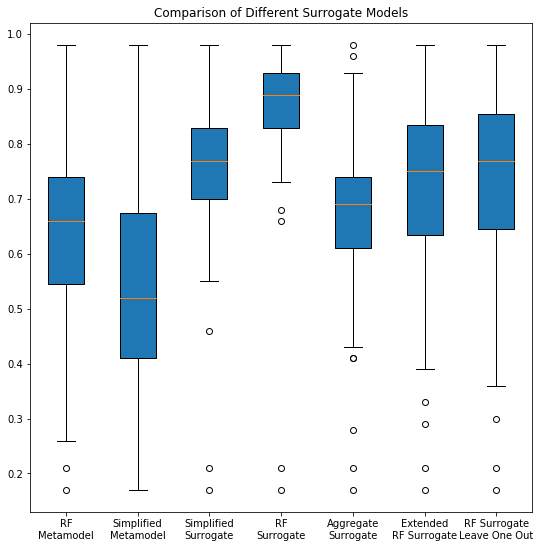

In [14]:
data = [rf_metamodel_scores, metamodel_scores,\
        simplified_surrogate_scores, rf_surrogate_scores,\
        aggregate_surrogate_scores, erf_metamodel_scores, rf_loo_scores]
labels = ['RF\nMetamodel', 'Simplified\nMetamodel', 'Simplified\nSurrogate',\
          'RF\nSurrogate', 'Aggregate\nSurrogate', 'Extended\nRF Surrogate', 'RF Surrogate\nLeave One Out']
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title('Comparison of Different Surrogate Models')
bplot = ax.boxplot(data, labels=labels, patch_artist=True, vert=True)
colors = ['red', 'blue', 'green', 'pink', 'cyan', 'black']
# for bp in bplot:
#     for patch, color in zip(bp['boxes'], colors):
#         patch.set_facecolor(color)
plt.show()

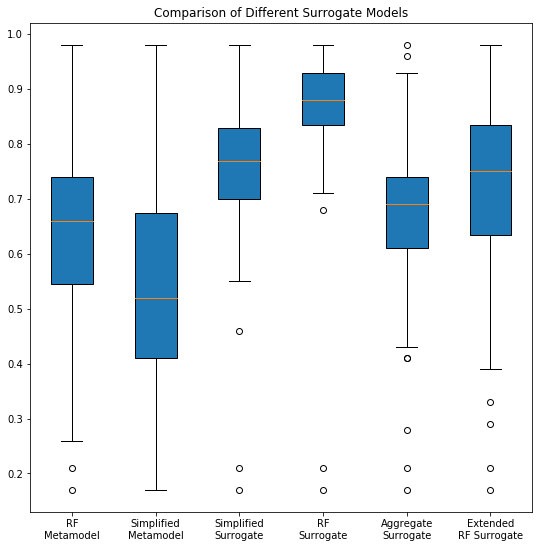

In [11]:
data = [rf_metamodel_scores, metamodel_scores,\
        simplified_surrogate_scores, rf_surrogate_scores,\
        aggregate_surrogate_scores, erf_metamodel_scores]
labels = ['RF\nMetamodel', 'Simplified\nMetamodel', 'Simplified\nSurrogate',\
          'RF\nSurrogate', 'Aggregate\nSurrogate', 'Extended\nRF Surrogate']
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title('Comparison of Different Surrogate Models')
bplot = ax.boxplot(data, labels=labels, patch_artist=True, vert=True)
colors = ['red', 'blue', 'green', 'pink', 'cyan', 'black']
# for bp in bplot:
#     for patch, color in zip(bp['boxes'], colors):
#         patch.set_facecolor(color)
plt.show()

In [12]:
with open('./data/all_scores.pkl', 'wb') as f:
    pickle.dump(data, f)

# Partial Dependency Plots

In [10]:
cs = ConfigSpace.ConfigurationSpace()
for idx, column in enumerate(df_meta):
    current_min = min(df_meta[column])
    current_max = max(df_meta[column])
    param = ConfigSpace.hyperparameters.UniformFloatHyperparameter(name=column, lower=current_min, upper=current_max)
    cs.add_hyperparameter(param)
print(cs)

Configuration space object:
  Hyperparameters:
    AutoCorrelation, Type: UniformFloat, Range: [0.0, 0.9999474210000526], Default: 0.4999737105
    Dimensionality, Type: UniformFloat, Range: [8.737249077128066e-05, 2.2784588441331], Default: 1.1392731083
    MajorityClassPercentage, Type: UniformFloat, Range: [1.0, 94.60632362058277], Default: 47.8031618103
    MajorityClassSize, Type: UniformFloat, Range: [16.0, 51827.0], Default: 25921.5
    MinorityClassPercentage, Type: UniformFloat, Range: [0.9380863039399625, 50.0], Default: 25.469043152
    MinorityClassSize, Type: UniformFloat, Range: [6.0, 46223.0], Default: 23114.5
    NumberOfBinaryFeatures, Type: UniformFloat, Range: [0.0, 35.0], Default: 17.5
    NumberOfClasses, Type: UniformFloat, Range: [2.0, 100.0], Default: 51.0
    NumberOfFeatures, Type: UniformFloat, Range: [4.0, 1777.0], Default: 890.5
    NumberOfInstances, Type: UniformFloat, Range: [500.0, 98050.0], Default: 49275.0
    NumberOfInstancesWithMissingValues, Type:

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Top 10 features for a are: Index(['NumberOfInstances', 'AutoCorrelation', 'MinorityClassSize',
       'MajorityClassPercentage', 'NumberOfSymbolicFeatures',
       'PercentageOfSymbolicFeatures', 'MinorityClassPercentage',
       'PercentageOfNumericFeatures', 'NumberOfClasses', 'Dimensionality'],
      dtype='object')
Marginal plots for a


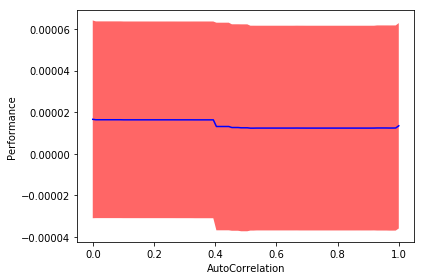

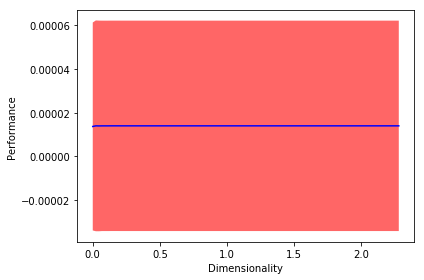

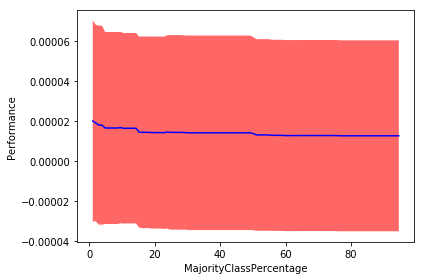

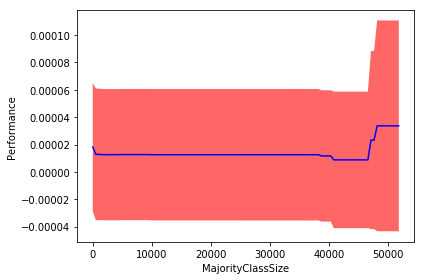

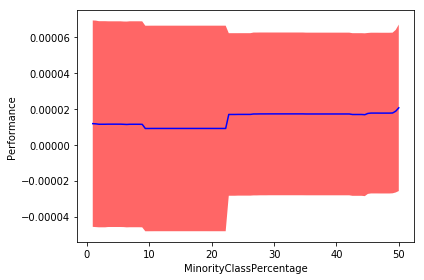

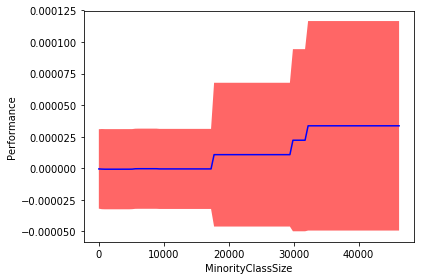

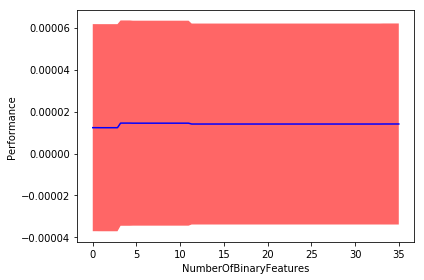

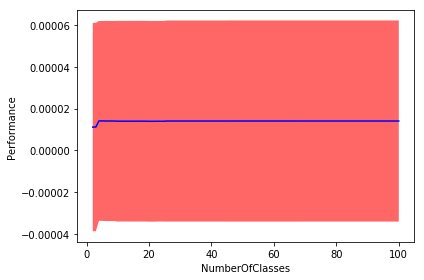

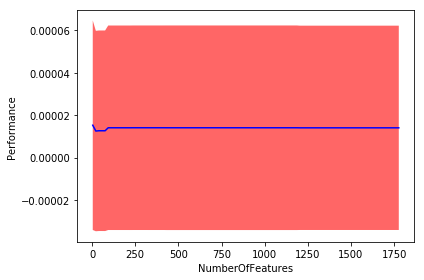

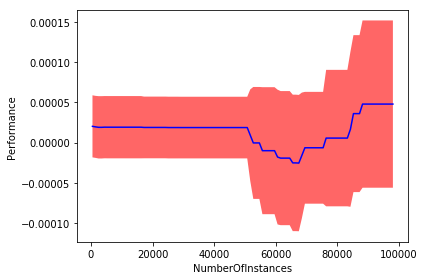

Top 10 features for b are: Index(['NumberOfInstances', 'AutoCorrelation', 'MinorityClassSize',
       'MajorityClassPercentage', 'NumberOfSymbolicFeatures',
       'PercentageOfSymbolicFeatures', 'MinorityClassPercentage',
       'PercentageOfNumericFeatures', 'NumberOfClasses', 'Dimensionality'],
      dtype='object')
Marginal plots for b


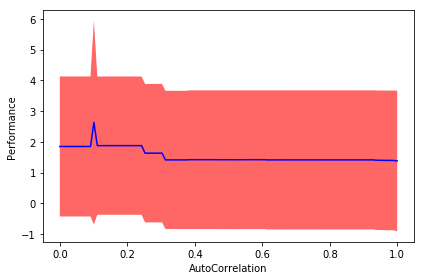

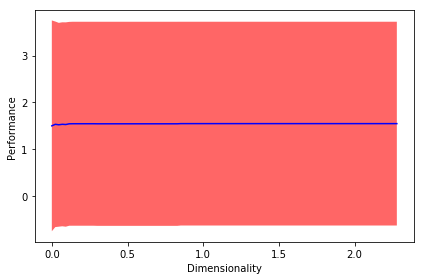

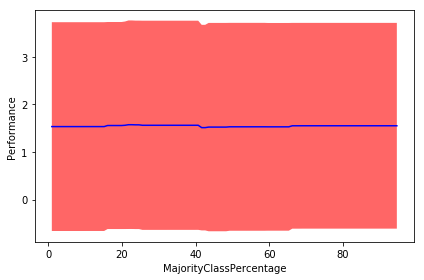

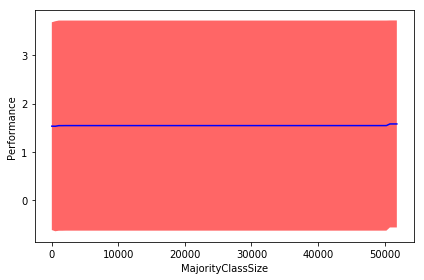

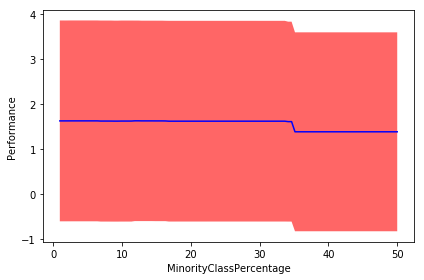

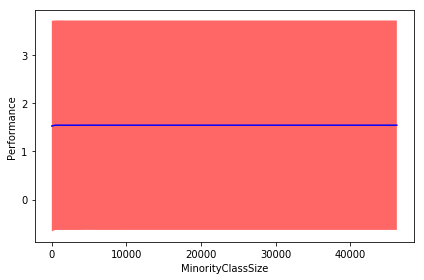

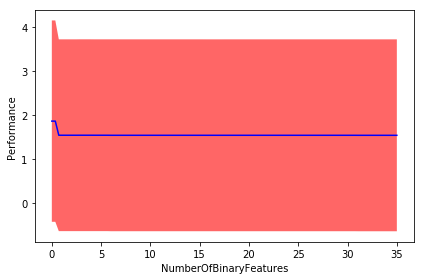

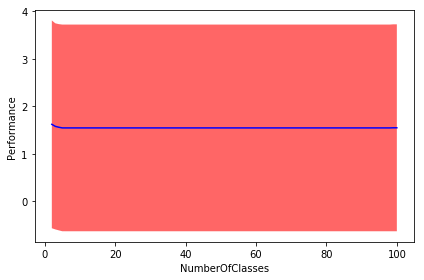

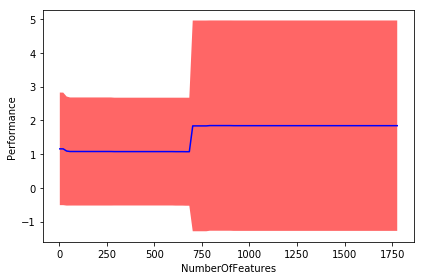

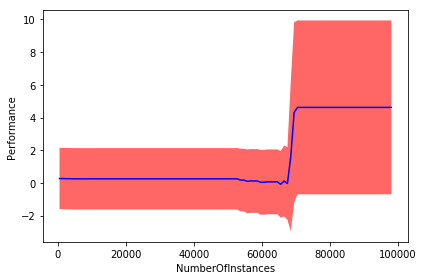

Top 10 features for c are: Index(['NumberOfInstances', 'AutoCorrelation', 'MinorityClassSize',
       'MajorityClassPercentage', 'NumberOfSymbolicFeatures',
       'PercentageOfSymbolicFeatures', 'MinorityClassPercentage',
       'PercentageOfNumericFeatures', 'NumberOfClasses', 'Dimensionality'],
      dtype='object')
Marginal plots for c


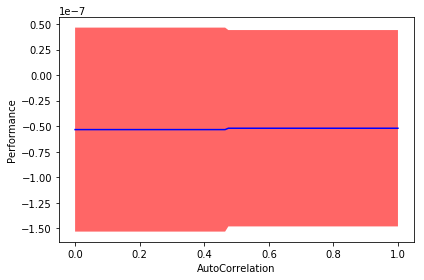

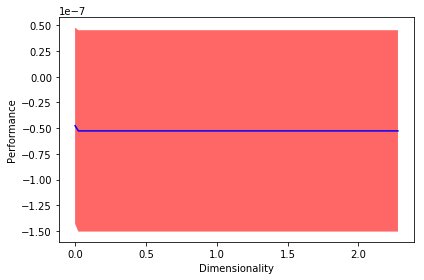

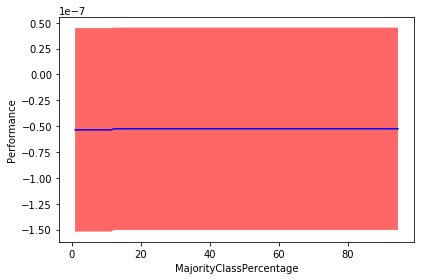

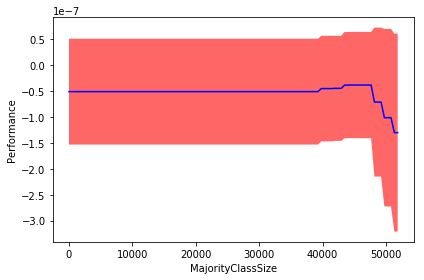

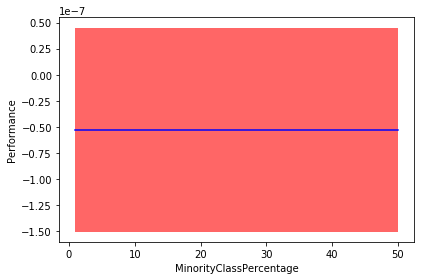

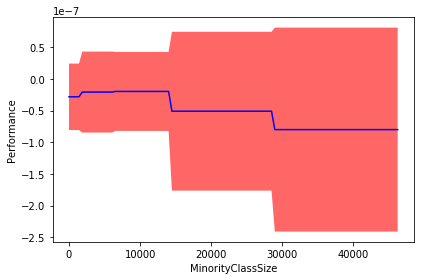

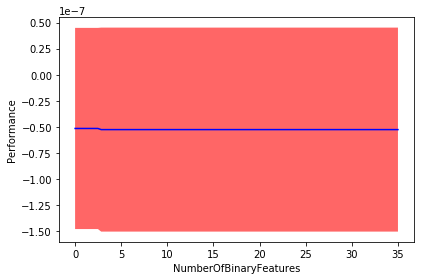

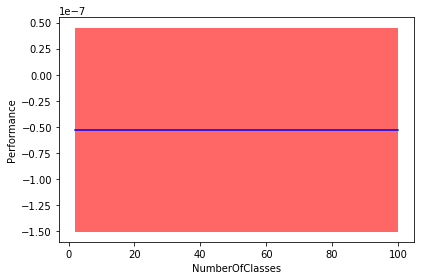

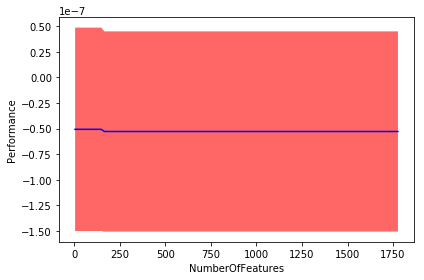

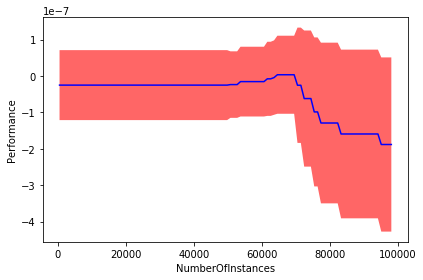

Top 10 features for d are: Index(['NumberOfInstances', 'AutoCorrelation', 'MinorityClassSize',
       'MajorityClassPercentage', 'NumberOfSymbolicFeatures',
       'PercentageOfSymbolicFeatures', 'MinorityClassPercentage',
       'PercentageOfNumericFeatures', 'NumberOfClasses', 'Dimensionality'],
      dtype='object')
Marginal plots for d


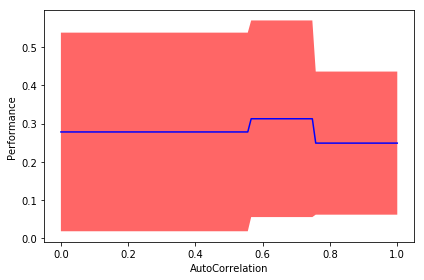

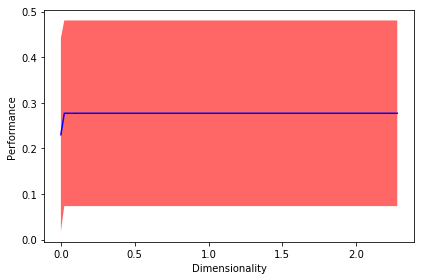

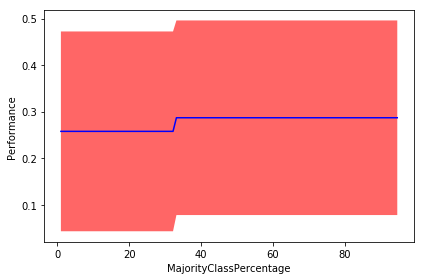

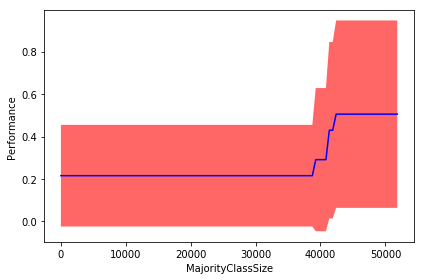

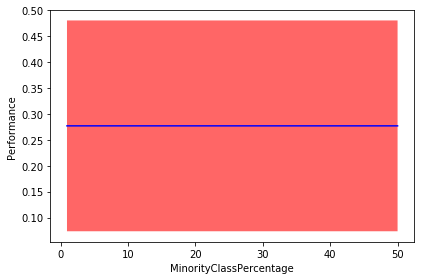

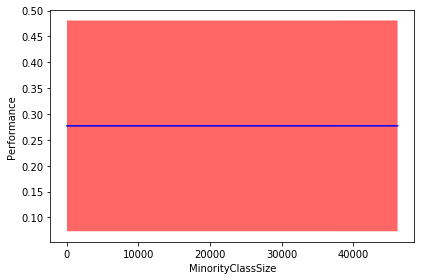

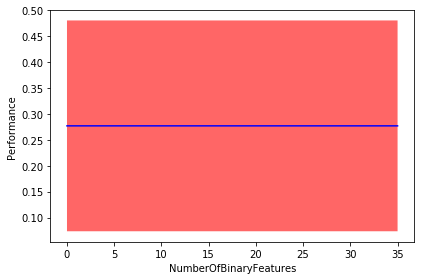

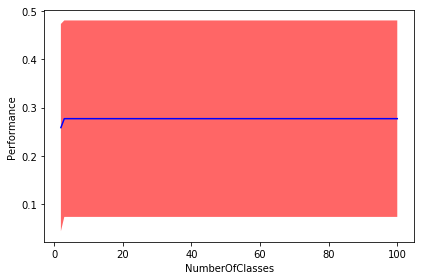

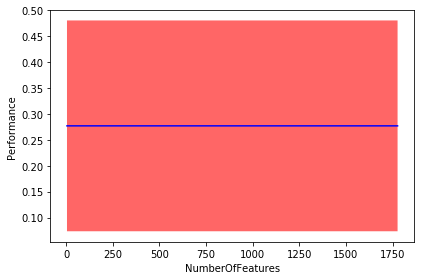

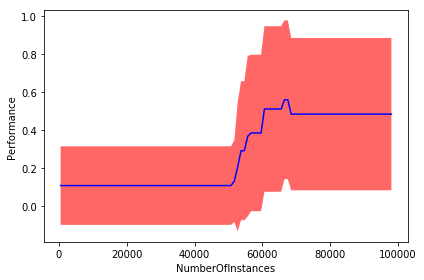

Top 10 features for e are: Index(['NumberOfInstances', 'AutoCorrelation', 'MinorityClassSize',
       'MajorityClassPercentage', 'NumberOfSymbolicFeatures',
       'PercentageOfSymbolicFeatures', 'MinorityClassPercentage',
       'PercentageOfNumericFeatures', 'NumberOfClasses', 'Dimensionality'],
      dtype='object')
Marginal plots for e


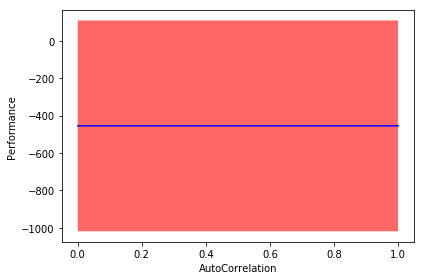

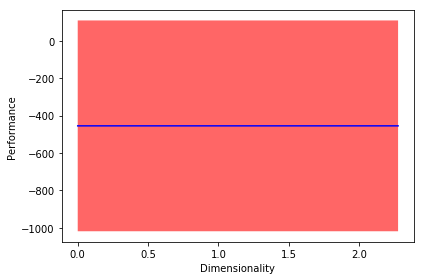

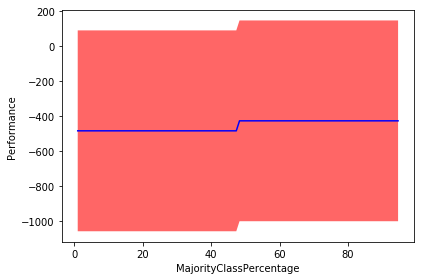

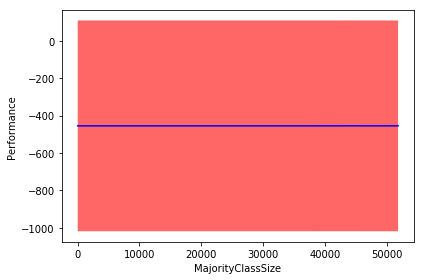

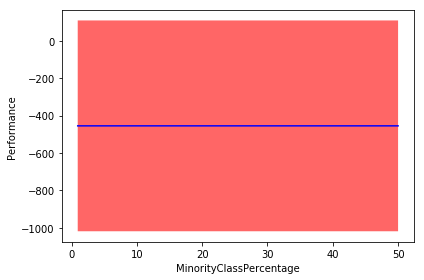

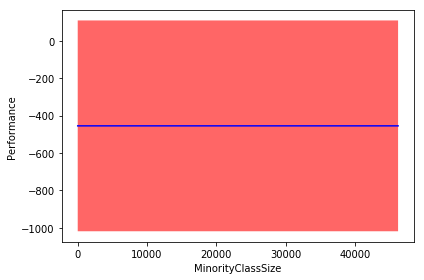

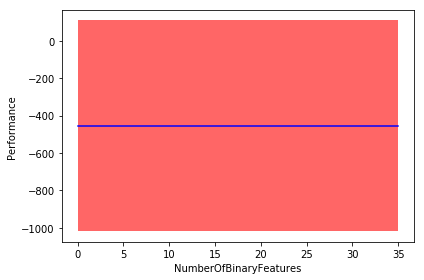

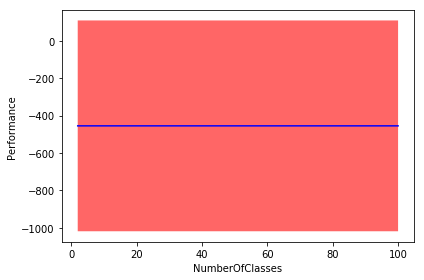

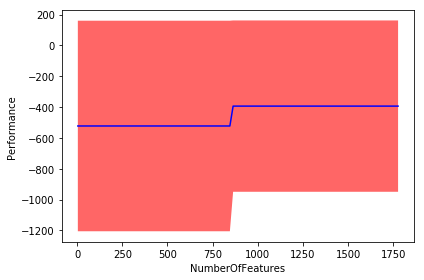

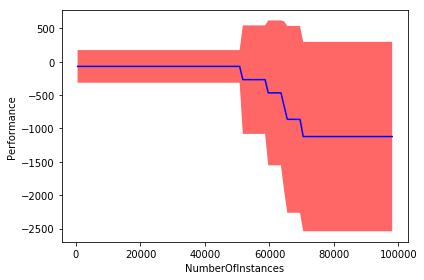

In [30]:
for i, co1_y in enumerate(df_model_params):
    f = fANOVA(df_meta.as_matrix(), df_model_params.as_matrix()[:,i])
    vis = fanova.visualizer.Visualizer(f, cs, "./plots/")
    importances = []
    for idx, feat in enumerate(df_meta.columns):
        importances.append(f.quantify_importance((idx,))[(idx,)]['total importance'])
    top10 = np.argsort(importances)[-1::-1][:10]
    print('Top 10 features for', co1_y, 'are:', df_meta.columns[top5])
    print("Marginal plots for", co1_y)
    for idx, feat in enumerate(top10):
        vis.plot_marginal(idx)

- for each param 5 most imp meta feat
- decision tree (max depth = 4) for RF metamodel (metafeatures -> (a-e)). No leave one out.
- plot feature importances of ERF do without leave one out
- Plot contour plots from leaves of DT (logC vs logGamma, f=parametric function from simplified model)
- use numpy geomspace to get C, gamma values on log scale
- Add f=intercept_ of linear model while predicting (a-f)